In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math
from pathlib import Path
import pmdarima as pm
import hvplot as hv
import warnings
import scipy.stats
from numpy.random import normal, seed
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [8]:
file_path = Path('data_parquet/buildings.parquet')
file_path2 = Path('data_parquet/demography.parquet')
file_path3 = Path('data_parquet/pois.parquet')
file_path4 = Path('data_parquet/roads.parquet')
file_path5 = Path('data_parquet/signals.parquet')
file_path6 = Path('data_parquet/traffic_test_without_target.parquet')
file_path7 = Path('data_parquet/traffic_train.parquet')

In [61]:
df_buildings = pd.read_parquet(file_path); df_buildings.name = 'Buildings'
df_demography = pd.read_parquet(file_path2); df_demography.name = 'Demography'
df_pois = pd.read_parquet(file_path3); df_pois.name = 'Pois'
df_roads = pd.read_parquet(file_path4); df_roads.name = 'Roads'
df_signals = pd.read_parquet(file_path5); df_signals.name = 'Signals'
df_traffic_test = pd.read_parquet(file_path6); df_traffic_test.name = 'Traffic'
df_traffic = pd.read_parquet(file_path7); df_traffic.name = 'Traffic Train'

In [63]:
# not for now
dfs = [df_buildings, df_demography, df_pois, df_roads, df_traffic_test]

In [65]:
for i in dfs:
    print(f'DF name: {i.name}')
    display(i.head(4))

DF name: Buildings


,h3res13,building_id,building_function,building_floors,building_flats,building_area
0,8d1f53cd3299dbf,3303EA7E-6861-33C1-E053-CA2BA8C02B7D,Agricultural Building,1.0,0,245.66
1,8d1f53cd3299d3f,3303EA7E-6861-33C1-E053-CA2BA8C02B7D,Agricultural Building,1.0,0,245.66
2,8d1f53cd3299cbf,3303EA7E-6861-33C1-E053-CA2BA8C02B7D,Agricultural Building,1.0,0,245.66
3,8d1f53cd329d6ff,3303EA7E-6861-33C1-E053-CA2BA8C02B7D,Agricultural Building,1.0,0,245.66


DF name: Demography


,h3res13,total,female0018,female1964,female6599,male0018,male1964,male6599
0,8d1f5224000837f,6.0,1.0,3.0,1.0,0.0,1.0,0.0
1,8d1f522400084bf,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,8d1f522400088ff,6.0,1.0,2.0,0.0,1.0,1.0,1.0
3,8d1f5224000943f,4.0,0.0,1.0,1.0,0.0,2.0,0.0


DF name: Pois


,h3res13,accommodation,active_life,arts_and_entertainment,attractions_and_activities,automotive,beauty_and_spa,business_to_business,eat_and_drink,education,...,mass_media,pets,private_establishments_and_corporates,professional_services,public_service_and_government,real_estate,religious_organization,retail,structure_and_geography,travel
0,8d1f52240b2923f,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8d1f52240b2ddbf,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8d1f52240b404ff,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,8d1f52240b434bf,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


DF name: Roads


,h3res13,bridleway,cycleway,footway,living_street,motorway,path,pedestrian,primary,residential,secondary,service,steps,tertiary,track,unclassified,unknown
0,8d1f5224034d37f,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,8d1f5224034da7f,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,8d1f5224036923f,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,8d1f522403692ff,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


DF name: Traffic


,station_id,date,street,segment,lat,lon,h3res13,hour
0,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,0
1,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,1
2,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,2
3,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,3


In [67]:
for i in dfs:
    print(f'DF name: {i.name}')
    i.info()

DF name: Buildings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440870 entries, 0 to 1440869
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   h3res13            1440870 non-null  object 
 1   building_id        1440870 non-null  object 
 2   building_function  1440870 non-null  object 
 3   building_floors    1435296 non-null  float64
 4   building_flats     1440870 non-null  int16  
 5   building_area      1440870 non-null  float64
dtypes: float64(2), int16(1), object(3)
memory usage: 57.7+ MB
DF name: Demography
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109678 entries, 0 to 109677
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   h3res13     109678 non-null  object 
 1   total       109600 non-null  float64
 2   female0018  109599 non-null  float64
 3   female1964  109599 non-null  float64
 4   female6599  109599 

# df traffic

In [49]:
# df_traffic.info()

In [69]:
del df_traffic['station_id'], df_traffic['street'], df_traffic['segment']

In [59]:
# df_traffic.head()

In [71]:
df_traffic.date = pd.to_datetime(df_traffic.date)

In [77]:
df_traffic['date_str'] = df_traffic['date'].dt.strftime('%Y-%m-%d')
df_traffic['hour'] = df_traffic['hour'].astype(str).str.zfill(2)
df_traffic['datetime'] = pd.to_datetime(df_traffic['date_str'] + ' ' + df_traffic['hour'] + ':00:00')

In [85]:
df_traffic_copy = df_traffic.copy()
df_traffic.shape

(102480, 8)

In [87]:
df_traffic.set_index('datetime', inplace=True)
# df_traffic.set_index('date', inplace=True)

In [89]:
df_traffic.shape

(102480, 7)

In [91]:
df_traffic = df_traffic.drop(['date','hour'], axis = 1)

In [97]:
df_traffic = df_traffic.drop(['date_str'], axis=1)

In [99]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102480 entries, 2024-03-01 00:00:00 to 2024-04-30 23:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   lat      102480 non-null  float64
 1   lon      102480 non-null  float64
 2   h3res13  102480 non-null  object 
 3   traffic  102480 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 7.9+ MB


In [103]:
df_traffic.head(10)

,lat,lon,h3res13,traffic
datetime,,,,
2024-03-01 00:00:00,52.165,20.9321,8d1f5224541113f,246
2024-03-01 01:00:00,52.165,20.9321,8d1f5224541113f,124
2024-03-01 02:00:00,52.165,20.9321,8d1f5224541113f,137
2024-03-01 03:00:00,52.165,20.9321,8d1f5224541113f,157
2024-03-01 04:00:00,52.165,20.9321,8d1f5224541113f,300
2024-03-01 05:00:00,52.165,20.9321,8d1f5224541113f,815
2024-03-01 06:00:00,52.165,20.9321,8d1f5224541113f,1955
2024-03-01 07:00:00,52.165,20.9321,8d1f5224541113f,3326
2024-03-01 08:00:00,52.165,20.9321,8d1f5224541113f,3048


In [109]:
df_traffic.index.freq

In [111]:
plt.style.use('ggplot')

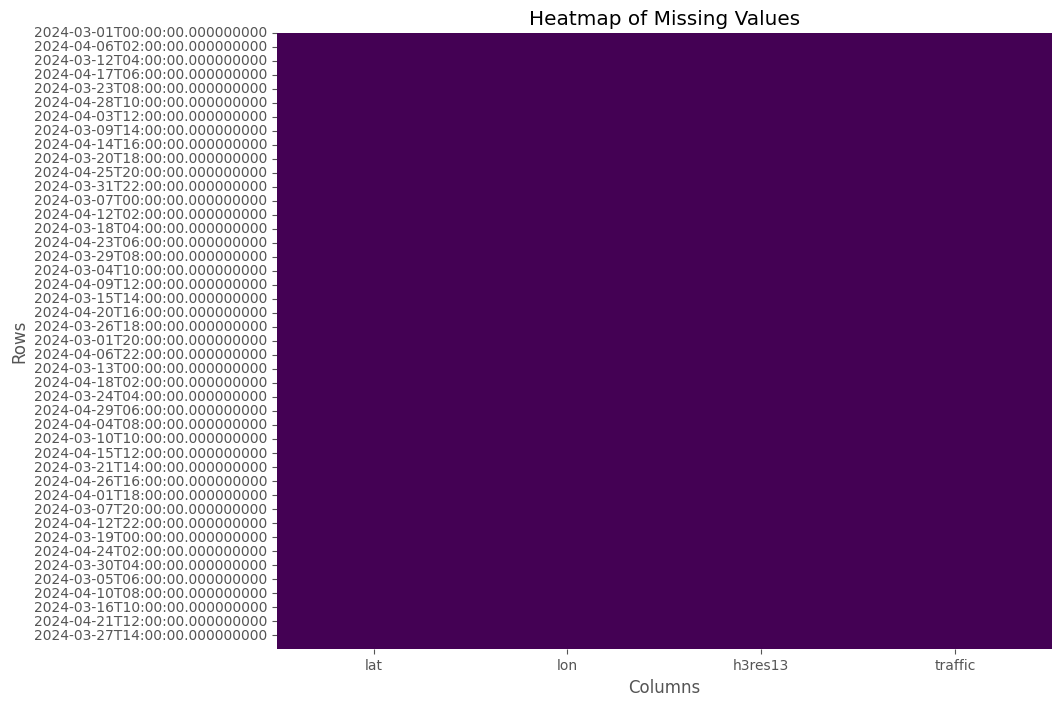

In [258]:
missing_values = df_traffic.isna()
missing_values_numeric = missing_values.astype(int)
plt.figure(figsize=(10, 8))
sns.heatmap(missing_values_numeric, cmap='viridis', cbar=False)
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [260]:
df_traffic.isna().sum()

lat        0
lon        0
h3res13    0
traffic    0
dtype: int64

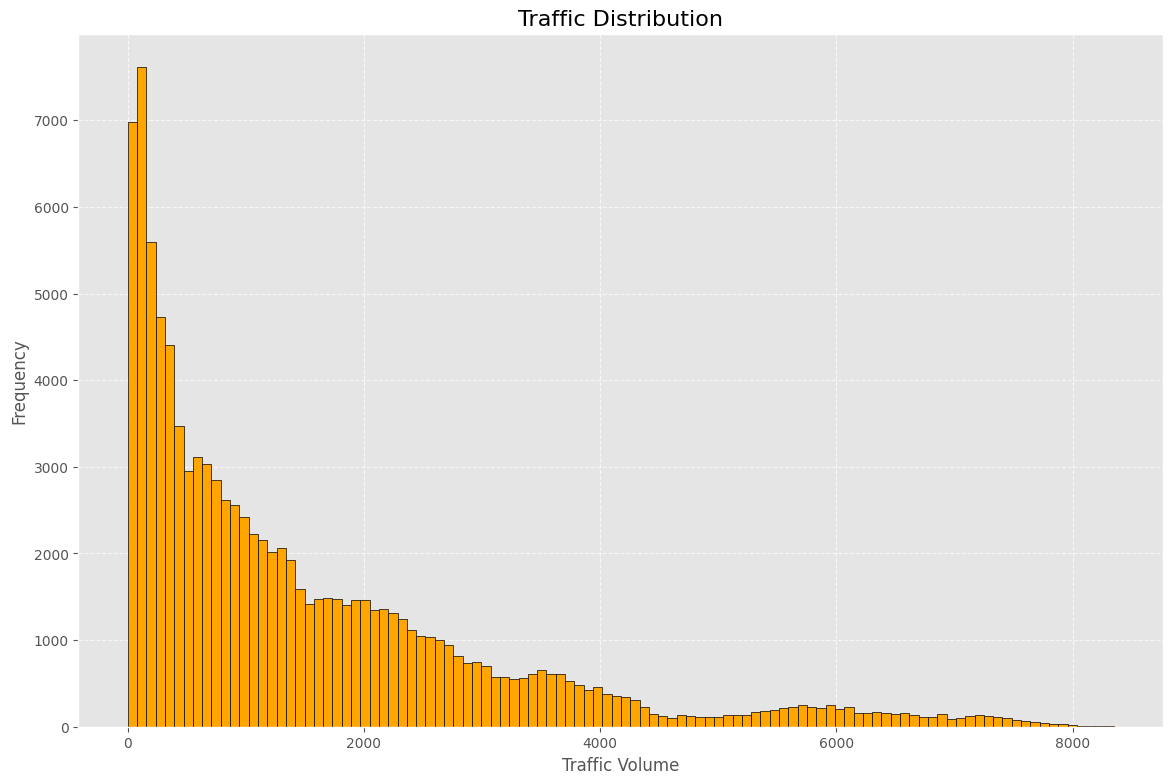

In [135]:
plt.figure(figsize=(14, 9))  # Adjusted to a more practical size
sns.histplot(df_traffic['traffic'], alpha=1, color='orange', edgecolor='black')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Traffic Distribution', fontsize=16)
plt.xlabel('Traffic Volume', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

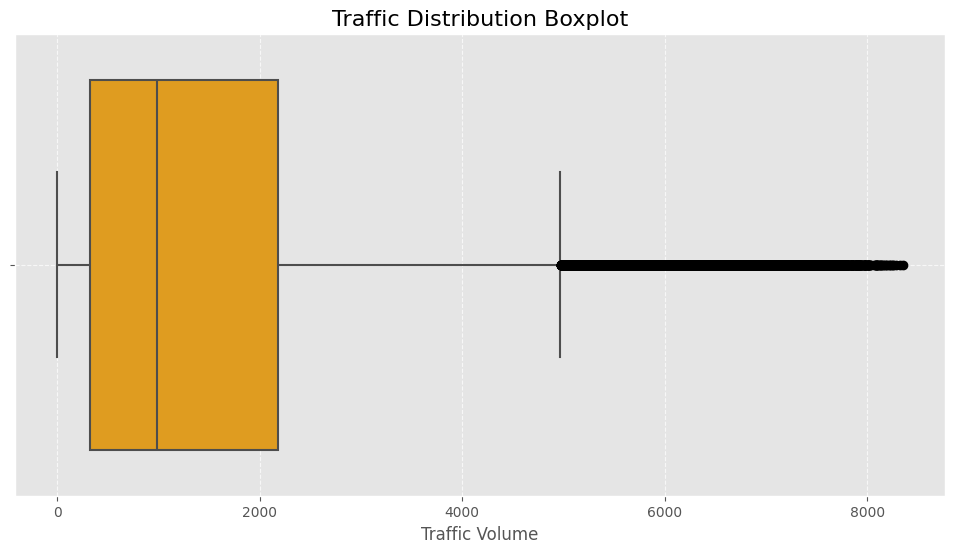

In [139]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_traffic['traffic'], orient='h', whis=1.5, color='orange', linewidth=1.5, 
            flierprops={'markerfacecolor': 'black', 'markeredgecolor': 'black'})
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Traffic Distribution Boxplot', fontsize=16)
plt.xlabel('Traffic Volume', fontsize=12)
plt.ylabel('')
plt.show()

In [144]:
from pandas.plotting import lag_plot

In [150]:
# lag_plot(df_traffic.traffic)

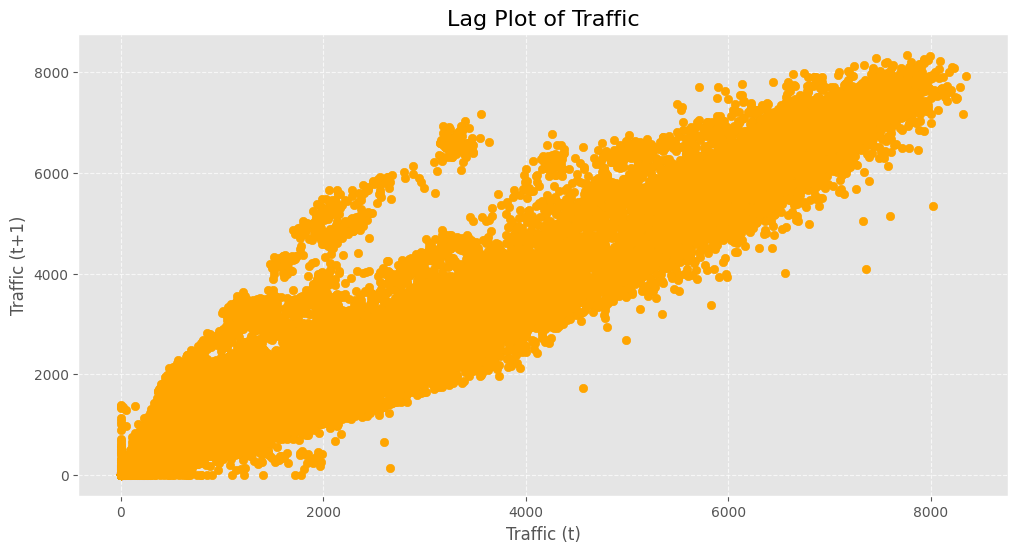

In [152]:
plt.figure(figsize=(12, 6))
plt.scatter(df_traffic['traffic'].iloc[:-1], df_traffic['traffic'].iloc[1:], color='orange', alpha=1)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.title('Lag Plot of Traffic', fontsize=16)
plt.xlabel('Traffic (t)', fontsize=12)
plt.ylabel('Traffic (t+1)', fontsize=12)
plt.show()

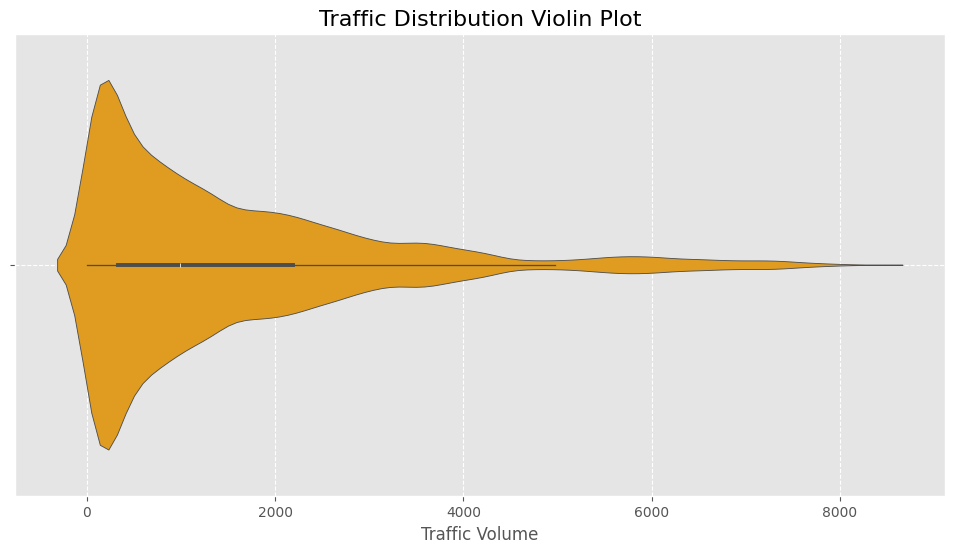

In [170]:
plt.figure(figsize=(12, 6))
sns.violinplot(df_traffic.traffic, orient='h', alpha=1, color='orange')
plt.grid(visible=True, linestyle='--', alpha=1)
plt.title('Traffic Distribution Violin Plot', fontsize=16)
plt.xlabel('Traffic Volume', fontsize=12)
plt.ylabel('')
plt.show()

In [172]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])  # Calculate the 25th and 75th percentiles
    IQR = q3 - q1  # Interquartile range
    lower_fence = q1 - (1.5 * IQR)  # Lower bound for outliers
    upper_fence = q3 + (1.5 * IQR)  # Upper bound for outliers
    return data[(data > upper_fence) | (data < lower_fence)] 

In [174]:
outliers = iqr_outliers(df_traffic.traffic)
outliers

datetime
2024-03-01 06:00:00    6493
2024-03-01 07:00:00    7275
2024-03-01 08:00:00    7340
2024-03-01 09:00:00    7482
2024-03-01 10:00:00    7516
                       ... 
2024-04-30 15:00:00    6540
2024-04-30 16:00:00    6789
2024-04-30 17:00:00    6093
2024-04-30 18:00:00    5546
2024-04-30 19:00:00    5430
Name: traffic, Length: 5452, dtype: int64

In [176]:
def zscore(df, column_name, degree=3):
    data = df.copy()
    data['zscore'] = (data[column_name] - data[column_name].mean()) / data[column_name].std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    return outliers[column_name], data

In [178]:
threshold = 2
outliers, transformed = zscore(df_traffic, 'traffic', threshold)

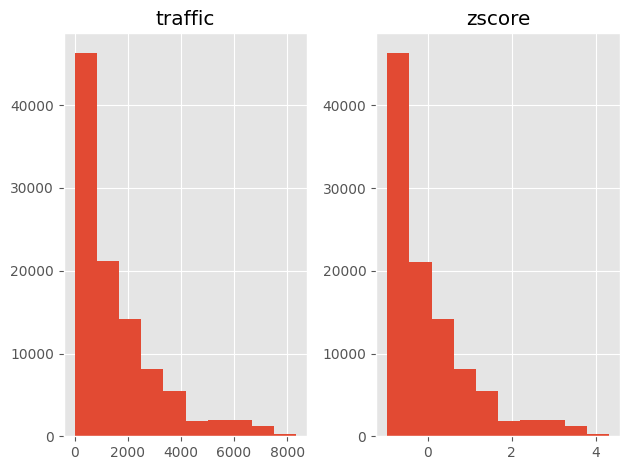

In [180]:
transformed[['traffic', 'zscore']].hist(); plt.tight_layout()

In [182]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(10, 6))
    plt.plot(data, 'k^')
    plt.plot([0, n], [d, d], 'r--')
    plt.plot([0, n], [-d, -d], 'r--')

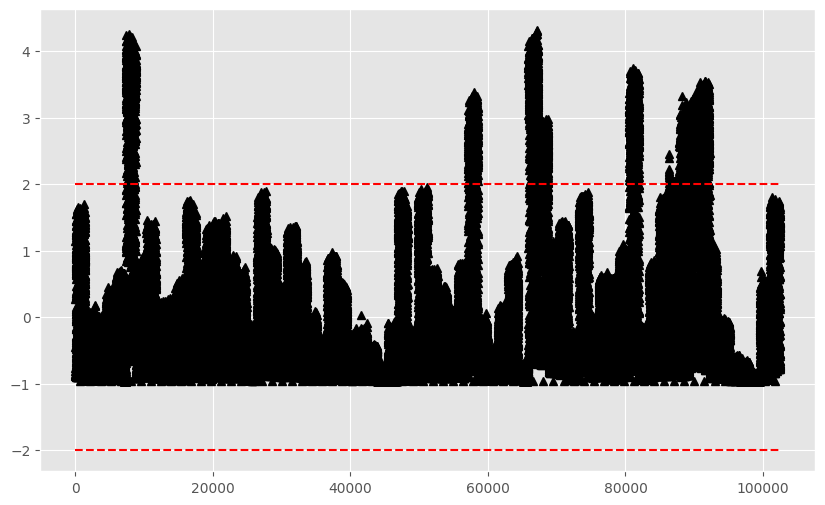

In [184]:
data = transformed['zscore'].values
plot_zscore(data, d=2)

In [186]:
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print('Reject null hypothesis. Data is not normally distributed')
    else:
        print('Fail to reject null hypothesis. Data is normally distributed')

In [188]:
test_normal(df_traffic.traffic)

Reject null hypothesis. Data is not normally distributed


In [190]:
from numpy.random import normal, seed
from scipy.stats import norm

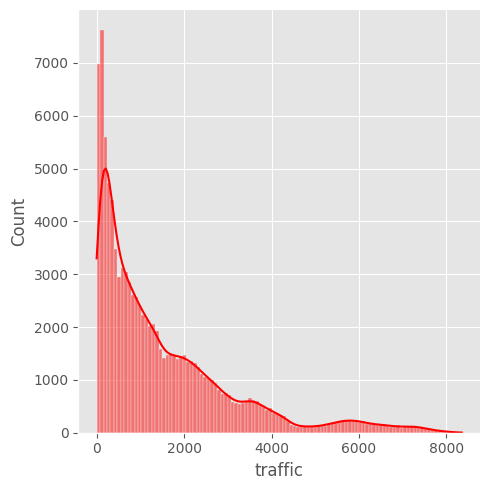

In [228]:
plt.style.use('ggplot')
sns.displot(df_traffic.traffic, kde=True, color='red'); plt.tight_layout()

In [230]:
import scipy.stats
import pylab

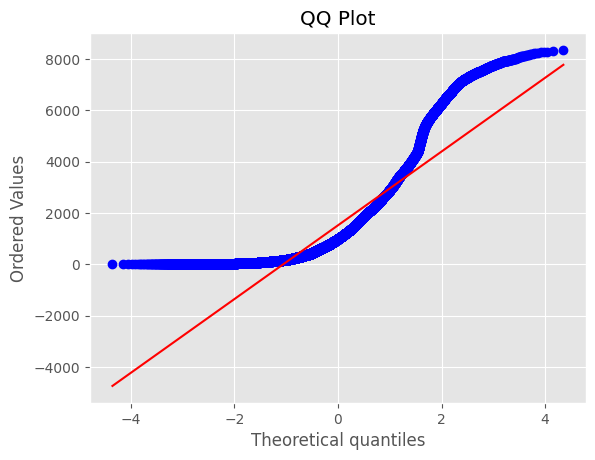

In [234]:
scipy.stats.probplot(df_traffic.traffic, plot=pylab)
plt.title('QQ Plot')
plt.show()

In [238]:
outliers.count()

5874

In [240]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test == 'kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
        'Test Statistic': test_score, 
        'p-value': pval,
        'Numbers of lags': lags, 
        'decision': decision
    }

    for key, value in critical.items():
        output_dict['Critical Value (%s)' % key] = value

    return pd.Series(output_dict, name=test)

In [244]:
adf_output = adfuller(df_traffic.traffic)
kpss_output = kpss(df_traffic.traffic)

In [246]:
pd.concat([print_results(adf_output, 'adf'), print_results(kpss_output, 'kpss')], axis=1)

,adf,kpss
Test Statistic,-6.96558,2.704394
p-value,0.0,0.01
Numbers of lags,68,145
decision,Stationary,Non-Stationary
Critical Value (1%),-3.430414,0.739
Critical Value (5%),-2.861568,0.463
Critical Value (10%),-2.566785,0.347
Critical Value (2.5%),NaN,0.574


In [262]:
adfuller(df_traffic.traffic)

(-6.965579688275563,
 8.933001176596326e-10,
 68,
 102411,
 {'1%': -3.4304138550928682,
  '5%': -2.8615682229579544,
  '10%': -2.5667850220916573},
 1384366.5391390482)

In [309]:
df_traffic_copy = df_traffic.copy()

In [311]:
df_traffic = df_traffic.resample('H').first()

In [313]:
df_traffic.index.freq

<Hour>

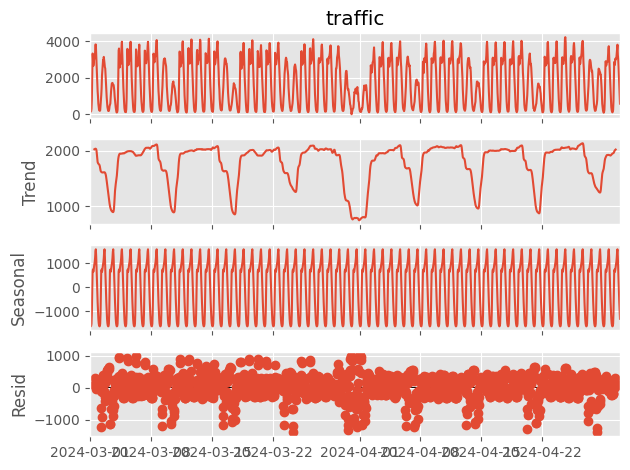

In [325]:
traffic_decomposed = seasonal_decompose(df_traffic.traffic, model='additive')
traffic_decomposed.plot(); plt.show()

<Axes: xlabel='datetime'>

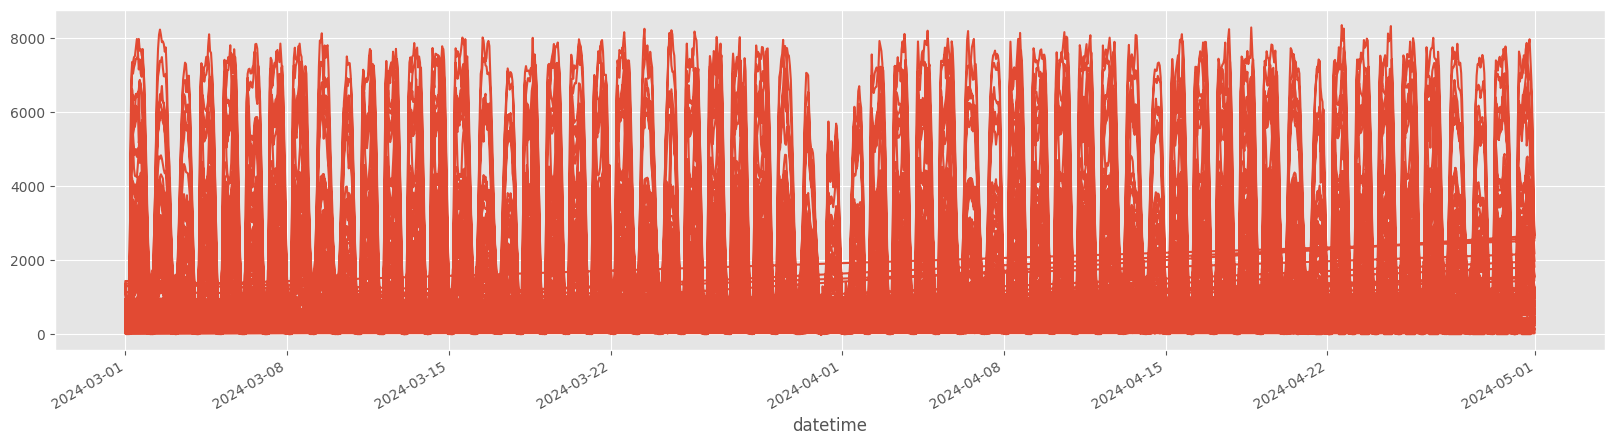

In [345]:
df_traffic_copy.traffic.plot(figsize=(20, 5))

In [349]:
adf_result = adfuller(df_traffic.traffic, store=True)
adf_result

(-5.374542378486775,
 3.830172283188919e-06,
 {'1%': -3.4349024693573584,
  '5%': -2.8635506057382325,
  '10%': -2.5678404322793846},
 <statsmodels.stats.diagnostic.ResultsStore at 0x1dfd49ea6f0>)

In [353]:
adf_result[-1].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     231.1
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:55:50   Log-Likelihood:                -9585.9
No. Observations:                1439   AIC:                         1.922e+04
Df Residuals:                    1413   BIC:                         1.936e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0752      0.014     -5.375      0.000      -0.103      -0.048
x2             0.5817      0.028     20.908      0.000       0.527       0.636
x3            -0.2514      0.032     -7.909      0.000      -0.314      -0.189
x4             0.0203      0.032      0.630      0.529      -0.043       0.084
x5             0.0305      0.032      0.952      0.341      -0.032       0.093
x6            -0.0733      0.032     -2.296      0.022      -0.136      -0.011
x7            -0.0275      0.032     -0.863      0.389      -0.090       0.035
x8            -0.0378      0.032     -1.191      0.234      -0.100       0.024
x9             0.0195      0.032      0.617      0.537      -0.042       0.081
x10            0.1018      0.031      3.277      0.001       0.041       0.163
x11           -0.1679      0.031     -5.392      0.000      -0.229      -0.107
x12            0.0060      0.031      0.193      0.847      -0.055       0.067
x13           -0.0676      0.031     -2.172      0.030      -0.129      -0.007
x14           -0.0520      0.031     -1.681      0.093      -0.113       0.009
x15           -0.0440      0.031     -1.420      0.156      -0.105       0.017
x16            0.0148      0.030      0.487      0.627      -0.045       0.074
x17           -0.1232      0.030     -4.056      0.000      -0.183      -0.064
x18           -0.0634      0.031     -2.076      0.038      -0.123      -0.003
x19           -0.0718      0.030     -2.374      0.018      -0.131      -0.012
x20           -0.0150      0.030     -0.498      0.619      -0.074       0.044
x21           -0.0256      0.030     -0.855      0.393      -0.084       0.033
x22           -0.0740      0.030     -2.477      0.013      -0.133      -0.015
x23           -0.0656      0.030     -2.194      0.028      -0.124      -0.007
x24            0.1425      0.029      4.974      0.000       0.086       0.199
x25            0.2691      0.026     10.525      0.000       0.219       0.319
const        133.1125     25.271      5.267      0.000      83.540     182.685
==============================================================================
Omnibus:                      207.764   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              742.343
Skew:                           0.680   Prob(JB):                    6.34e-162
Kurtosis:                       6.245   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Power Transformations

In [358]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal

In [360]:
def is_normal(test, p_level = 0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [362]:
normal_args = (np.mean(df_traffic.traffic), np.std(df_traffic.traffic))

In [364]:
shapiro(df_traffic.traffic)

ShapiroResult(statistic=0.9093875373013911, pvalue=1.16197026167384e-28)

In [366]:
print(is_normal(shapiro(df_traffic.traffic)))

Not Normal


In [368]:
print(is_normal(normaltest(df_traffic.traffic)))

Not Normal


In [370]:
print(is_normal(kstest_normal(df_traffic.traffic)))

Not Normal


In [374]:
print(is_normal(kstest(df_traffic.traffic, cdf='norm', 
                      args=(np.mean(df_traffic.traffic), np.std(df_traffic.traffic)))))

Not Normal


In [376]:
from statsmodels.tsa.api import AutoReg
model = AutoReg(df_traffic.traffic.dropna(), lags = 1).fit()

In [378]:
print(is_normal(shapiro(model.resid)))

Not Normal


The output indicates the residuals are not normally distributed. This fact, residuals not being normally distributed, is not enough to determine the model's validity or potential improvements. But taken into context with the other tests, it should help you determine how good your model is.

## Homoskedactisity

In [386]:
from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

In [388]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, sm.add_constant(model.fittedvalues))
    )
    return 'Heteroskedastic' if f_pvalue < 0.05 else 'Homoskedastic'

In [390]:
het_test(model, test=het_breuschpagan)

'Homoskedastic'

In [398]:
het_test(model, test=het_white)

'Homoskedastic'

## Box-Cox transform

In [403]:
from scipy.stats import boxcox # from non-normal to normal distribution

In [407]:
min_value = df_traffic['traffic'].min()
if min_value <= 0:
    df_traffic['traffic'] = df_traffic['traffic'] + abs(min_value) + 1
xt, lmbda = boxcox(df_traffic['traffic'])
xts = pd.Series(xt, index=df_traffic.index)
print(f"Lambda: {lmbda}")
print(xts.head())

Lambda: 0.5030970556513705
datetime
2024-03-01 00:00:00    29.788882
2024-03-01 01:00:00    20.570150
2024-03-01 02:00:00    21.721413
2024-03-01 03:00:00    23.391991
2024-03-01 04:00:00    33.112362
Freq: h, dtype: float64


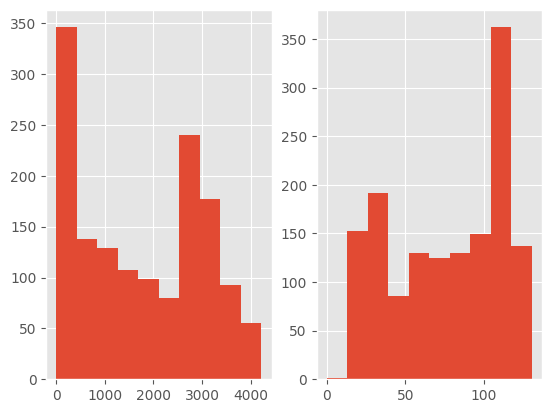

In [423]:
fig, ax = plt.subplots(1, 2)
df_traffic.traffic.hist(ax=ax[0])
xts.hist(ax=ax[1])
plt.show()

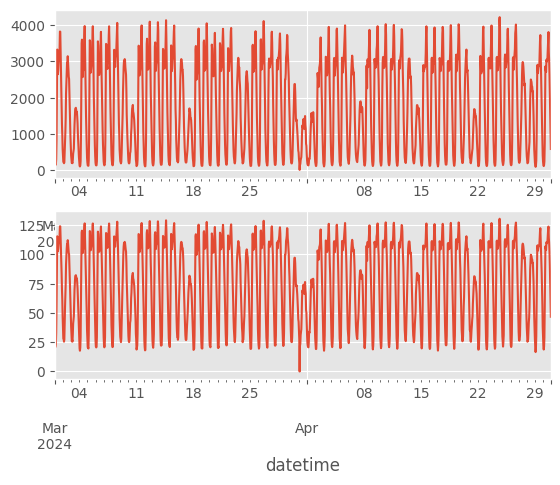

In [427]:
fig, ax = plt.subplots(2, 1)
df_traffic.traffic.plot(ax=ax[0]) # Original Time Series
xts.plot(ax=ax[1]) # Box-Cox Transformed
plt.show()

In [431]:
xts.var()

1210.1622870020205

In [433]:
df_traffic.traffic.var()

1552915.3642283822

In [435]:
shapiro(xts)

ShapiroResult(statistic=0.9072181995604593, pvalue=5.981609065524367e-29)

In [437]:
print(is_normal(shapiro(xts)))

Not Normal


In [439]:
model_1 = AutoReg(df_traffic.traffic, lags = 1, trend='n').fit()
model_bx = AutoReg(xts, lags = 1, trend='n').fit()

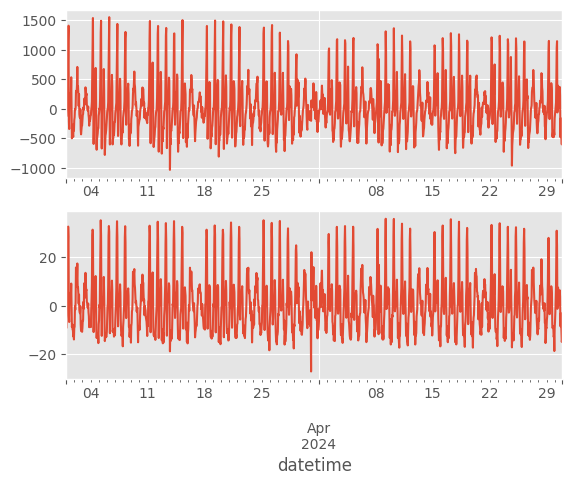

In [441]:
fig, ax = plt.subplots(2, 1)
model_1.resid.plot(ax=ax[0]) # Original TS model residuals
model_bx.resid.plot(ax=ax[1]) # Box-Cox transformed model residuals
plt.show()

In [443]:
print(model_bx.diagnostic_summary())

             Test of Normality              
Jarque-Bera    P-value   Skewness   Kurtosis
--------------------------------------------
    275.664      0.000      0.972      3.862


    Test of Conditional Homoskedasticity   
       Lag    ARCH-LM    P-value         DF
-------------------------------------------
         1    557.323      0.000          1
         2    746.094      0.000          2
         3    749.889      0.000          3
         4    754.656      0.000          4
         5    760.862      0.000          5
         6    760.260      0.000          6
         7    761.552      0.000          7
         8    763.438      0.000          8
         9    767.591      0.000          9
        10    769.479      0.000         10
-------------------------------------------


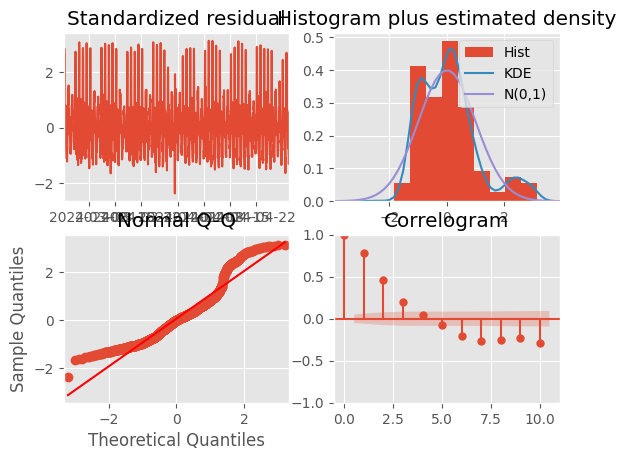

In [447]:
model_bx.plot_diagnostics(); plt.show()

In [449]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [451]:
acorr_ljungbox(df_traffic.traffic, lags = 10, return_df = True)

,lb_stat,lb_pvalue
1,1296.963214,5.166048e-284
2,2231.495629,0.000000e+00
3,2796.255171,0.000000e+00
4,3069.765818,0.000000e+00
5,3153.410259,0.000000e+00
6,3157.030545,0.000000e+00
7,3179.743962,0.000000e+00
8,3294.432455,0.000000e+00
9,3557.037708,0.000000e+00
10,4007.551879,0.000000e+00


In [453]:
acorr_ljungbox(model_bx.resid, return_df = True, lags = 10)

,lb_stat,lb_pvalue
1,899.477391,1.274764e-197
2,1218.425502,2.644016e-265
3,1277.832519,9.499716e-277
4,1281.243307,3.879984e-276
5,1289.850638,1.009556e-276
6,1348.788003,2.968191e-288
7,1453.811166,8.760509e-310
8,1549.292196,0.000000e+00
9,1628.827566,0.000000e+00
10,1749.309210,0.000000e+00


<Axes: xlabel='datetime'>

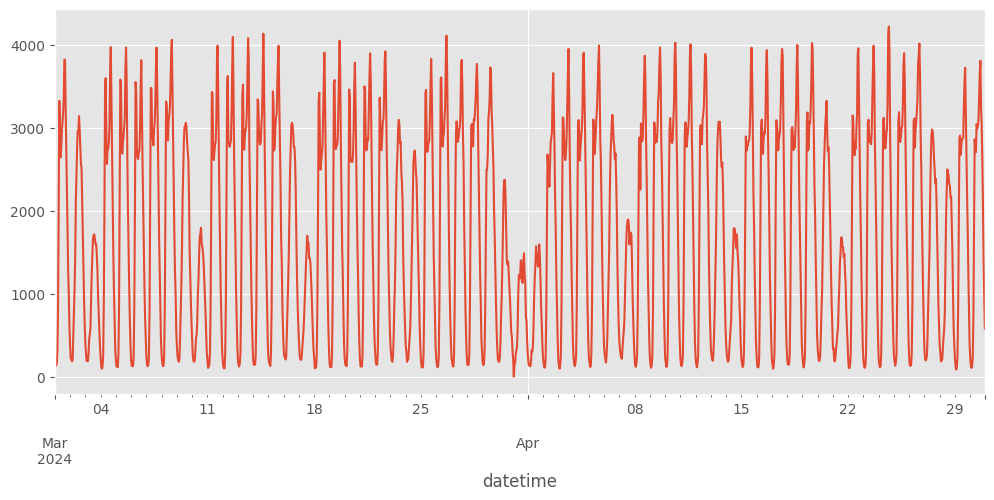

In [459]:
df_traffic.traffic.plot(figsize=(12, 5))

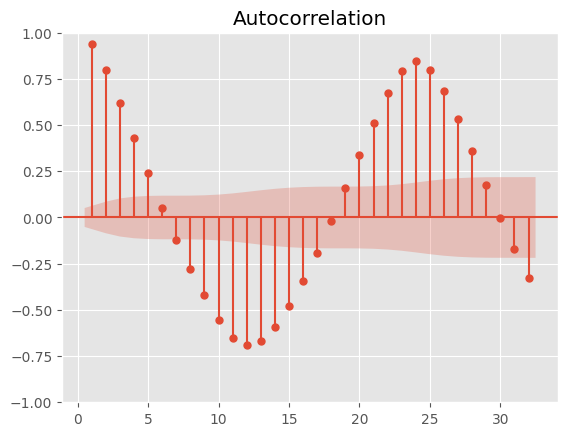

In [465]:
plot_acf(df_traffic.traffic, zero=False); plt.show()

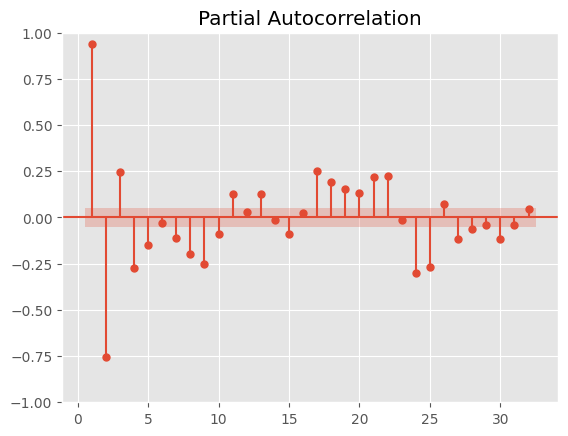

In [469]:
plot_pacf(df_traffic.traffic, zero=False, method=('ols')); plt.show()

In [471]:
df_traffic.traffic.mean()

1776.1571038251366

In [473]:
df_traffic.traffic.min()

1

In [475]:
df_traffic.traffic.max()

4222

In [477]:
df_traffic.traffic.var()

1552915.3642283822

In [483]:
# mean absolute error

In [481]:
mae = np.mean(np.abs(df_traffic.traffic))
mae

1776.1571038251366

In [513]:
model_sarima_traffic = SARIMAX(df_traffic.traffic, order=(2, 0, 0), 
                              seasonal_order=(2, 0, 0, 24))

In [515]:
result_sarima_traffic = model_sarima_traffic.fit()

In [517]:
print(result_sarima_traffic.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            traffic   No. Observations:                 1464
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood               -9951.770
Date:                            Sun, 13 Apr 2025   AIC                          19913.541
Time:                                    00:29:44   BIC                          19939.985
Sample:                                03-01-2024   HQIC                         19923.404
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4273      0.012    120.923      0.000       1.404       1.450
ar.L2         -0.5065      0.013   

In [519]:
resid_sarima_traffic = result_sarima_traffic.resid

In [521]:
mae = np.mean(np.abs(resid_sarima_traffic))
mae

145.68553965276078

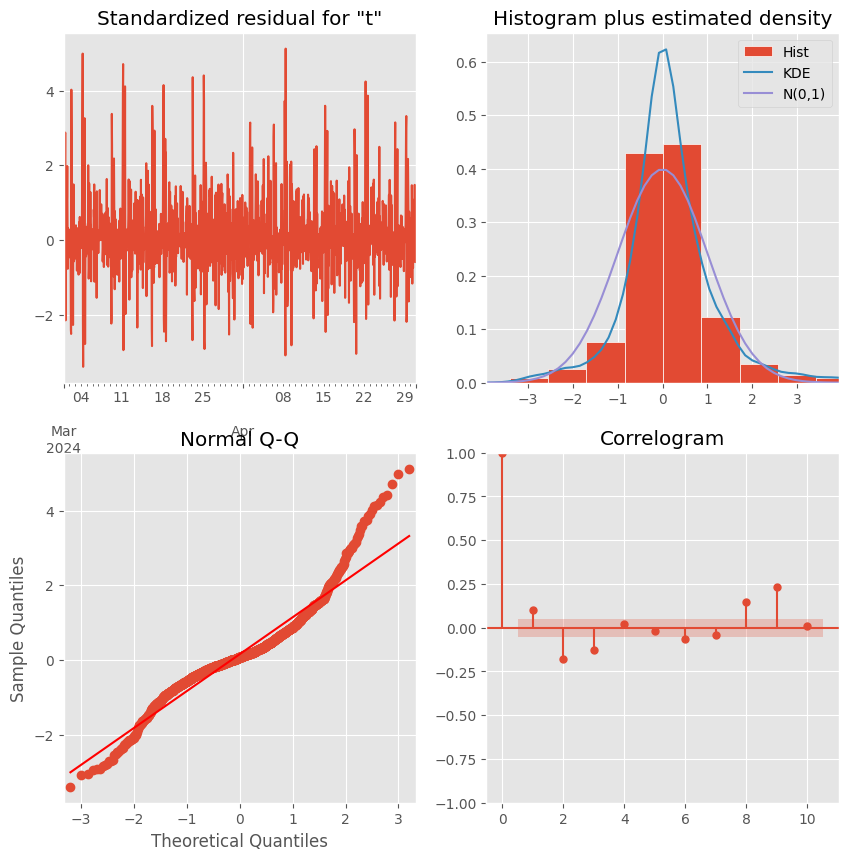

In [523]:
result_sarima_traffic.plot_diagnostics(figsize=(10, 10)); plt.show()

In [565]:
model_sarima2_traffic = SARIMAX(df_traffic.traffic, order=(3, 0, 1), 
                              seasonal_order=(3, 0, 1, 24))

In [567]:
result_sarima2_traffic = model_sarima2_traffic.fit()

In [569]:
print(result_sarima2_traffic.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            traffic   No. Observations:                 1464
Model:             SARIMAX(3, 0, 1)x(3, 0, 1, 24)   Log Likelihood               -9871.708
Date:                            Sun, 13 Apr 2025   AIC                          19761.415
Time:                                    00:38:41   BIC                          19809.015
Sample:                                03-01-2024   HQIC                         19779.169
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8809      0.104     18.054      0.000       1.677       2.085
ar.L2         -1.3625      0.149   

In [571]:
resid_sarima2_traffic = result_sarima2_traffic.resid

In [573]:
mae = np.mean(np.abs(resid_sarima2_traffic))
mae

135.99058386940732

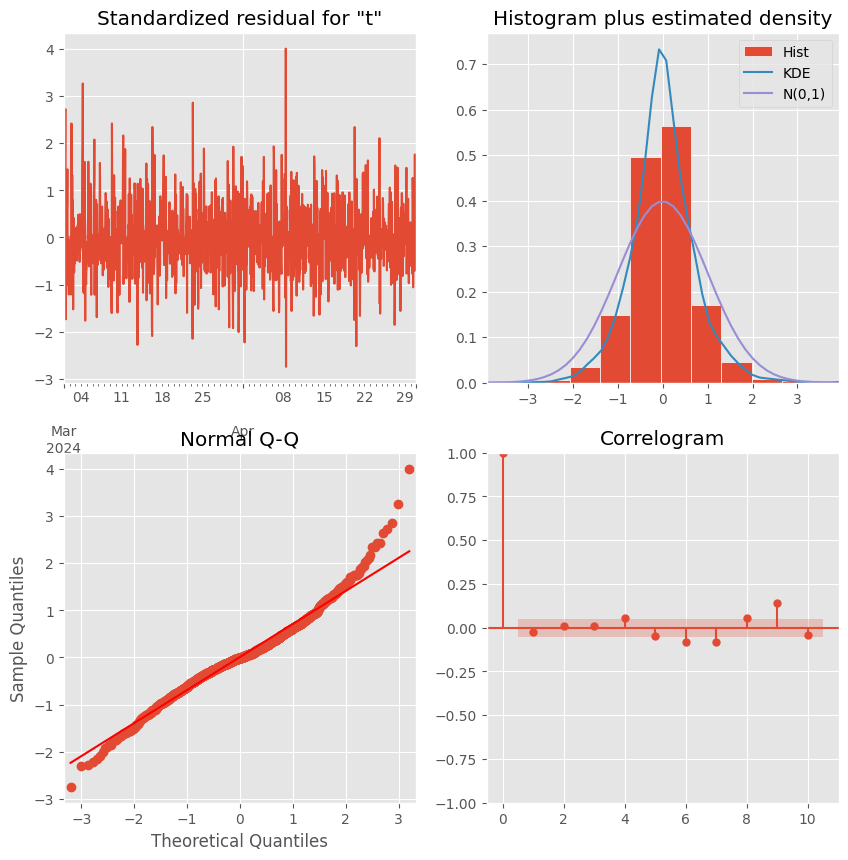

In [575]:
result_sarima2_traffic.plot_diagnostics(figsize=(10, 10)); plt.show()

In [577]:
from scipy.stats.distributions import chi2
def LLR_test(mod_1, mod_2, DF=1): # DF -> degrees of freedom
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [579]:
LLR_test(model_sarima_traffic, model_sarima2_traffic)

1.0

In [581]:
LLR_test(model_sarima2_traffic, model_sarima_traffic)

0.0

In [585]:
model_sarimax_traffic = SARIMAX(df_traffic.traffic, order=(2, 0, 0), 
                seasonal_order=(2, 0, 0, 24), 
                exog=df_traffic[['lat', 'lon']])

In [587]:
result_sarimax_traffic = model_sarimax_traffic.fit()

In [591]:
print(result_sarimax_traffic.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            traffic   No. Observations:                 1464
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood               -9919.626
Date:                            Sun, 13 Apr 2025   AIC                          19853.252
Time:                                    00:50:10   BIC                          19890.274
Sample:                                03-01-2024   HQIC                         19867.061
                                     - 04-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lat           29.7723      2.926     10.174      0.000      24.037      35.508
lon           11.9466      1.074   

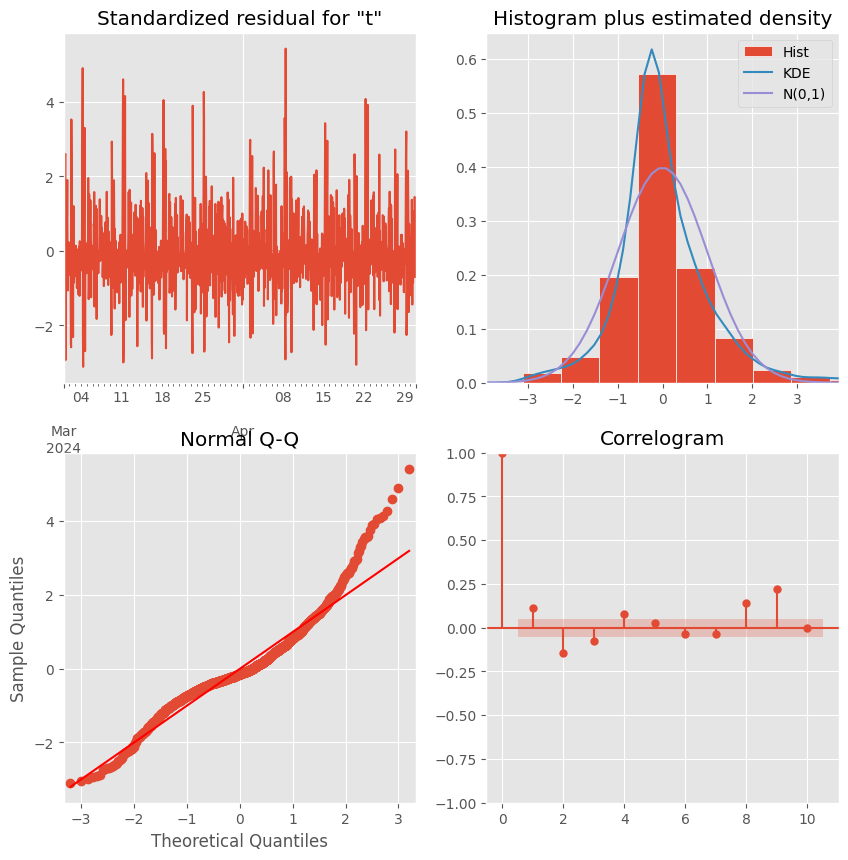

In [595]:
result_sarimax_traffic.plot_diagnostics(figsize=(10, 10)); plt.show()

# signals

In [600]:
df_signals.head()

,h3res13,signal_date,weekday,ctn_per_day,ctd_per_day,ctn_0,ctn_1,ctn_2,ctn_3,ctn_4,...,ctd_14,ctd_15,ctd_16,ctd_17,ctd_18,ctd_19,ctd_20,ctd_21,ctd_22,ctd_23
0,8d1f52240a6107f,2024-03-01,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8d1f52240a6107f,2024-03-02,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8d1f52240a6107f,2024-03-03,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8d1f52240a6107f,2024-03-04,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8d1f52240a6107f,2024-03-05,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [606]:
df_signals.tail()

,h3res13,signal_date,weekday,ctn_per_day,ctd_per_day,ctn_0,ctn_1,ctn_2,ctn_3,ctn_4,...,ctd_14,ctd_15,ctd_16,ctd_17,ctd_18,ctd_19,ctd_20,ctd_21,ctd_22,ctd_23
24072547,8d1f53d9d6decff,2024-04-26,5,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
24072548,8d1f53d9d6decff,2024-04-27,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24072549,8d1f53d9d6decff,2024-04-28,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24072550,8d1f53d9d6decff,2024-04-29,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24072551,8d1f53d9d6decff,2024-04-30,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [602]:
df_signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24072552 entries, 0 to 24072551
Data columns (total 53 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   h3res13      object
 1   signal_date  object
 2   weekday      int8  
 3   ctn_per_day  int16 
 4   ctd_per_day  int8  
 5   ctn_0        int16 
 6   ctn_1        int16 
 7   ctn_2        int16 
 8   ctn_3        int16 
 9   ctn_4        int16 
 10  ctn_5        int16 
 11  ctn_6        int16 
 12  ctn_7        int16 
 13  ctn_8        int16 
 14  ctn_9        int16 
 15  ctn_10       int16 
 16  ctn_11       int16 
 17  ctn_12       int16 
 18  ctn_13       int16 
 19  ctn_14       int16 
 20  ctn_15       int16 
 21  ctn_16       int16 
 22  ctn_17       int16 
 23  ctn_18       int16 
 24  ctn_19       int16 
 25  ctn_20       int16 
 26  ctn_21       int16 
 27  ctn_22       int16 
 28  ctn_23       int16 
 29  ctd_0        int8  
 30  ctd_1        int8  
 31  ctd_2        int8  
 32  ctd_3        int8  
 33  ctd_4

In [604]:
df_signals.shape

(24072552, 53)

In [620]:
df_signals.tail()

,h3res13,signal_date,weekday,ctn_per_day,ctd_per_day,ctn_0,ctn_1,ctn_2,ctn_3,ctn_4,...,datetime_8,datetime_9,datetime_10,datetime_11,datetime_12,datetime_13,datetime_14,datetime_15,datetime_16,datetime_17
24072547,8d1f53d9d6decff,2024-04-26,5,1,1,0,0,0,0,0,...,2024-04-26 08:00:00,2024-04-26 09:00:00,2024-04-26 10:00:00,2024-04-26 11:00:00,2024-04-26 12:00:00,2024-04-26 13:00:00,2024-04-26 14:00:00,2024-04-26 15:00:00,2024-04-26 16:00:00,2024-04-26 17:00:00
24072548,8d1f53d9d6decff,2024-04-27,6,0,0,0,0,0,0,0,...,2024-04-27 08:00:00,2024-04-27 09:00:00,2024-04-27 10:00:00,2024-04-27 11:00:00,2024-04-27 12:00:00,2024-04-27 13:00:00,2024-04-27 14:00:00,2024-04-27 15:00:00,2024-04-27 16:00:00,2024-04-27 17:00:00
24072549,8d1f53d9d6decff,2024-04-28,7,0,0,0,0,0,0,0,...,2024-04-28 08:00:00,2024-04-28 09:00:00,2024-04-28 10:00:00,2024-04-28 11:00:00,2024-04-28 12:00:00,2024-04-28 13:00:00,2024-04-28 14:00:00,2024-04-28 15:00:00,2024-04-28 16:00:00,2024-04-28 17:00:00
24072550,8d1f53d9d6decff,2024-04-29,1,0,0,0,0,0,0,0,...,2024-04-29 08:00:00,2024-04-29 09:00:00,2024-04-29 10:00:00,2024-04-29 11:00:00,2024-04-29 12:00:00,2024-04-29 13:00:00,2024-04-29 14:00:00,2024-04-29 15:00:00,2024-04-29 16:00:00,2024-04-29 17:00:00
24072551,8d1f53d9d6decff,2024-04-30,2,0,0,0,0,0,0,0,...,2024-04-30 08:00:00,2024-04-30 09:00:00,2024-04-30 10:00:00,2024-04-30 11:00:00,2024-04-30 12:00:00,2024-04-30 13:00:00,2024-04-30 14:00:00,2024-04-30 15:00:00,2024-04-30 16:00:00,2024-04-30 17:00:00


# Test

In [625]:
df_traffic_test.head()

,station_id,date,street,segment,lat,lon,h3res13,hour
0,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,0
1,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,1
2,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,2
3,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,3
4,1313,2024-03-01,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,4


In [661]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2024-03-01 00:00:00 to 2024-04-30 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lat      1464 non-null   float64
 1   lon      1464 non-null   float64
 2   h3res13  1464 non-null   object 
 3   traffic  1464 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 89.5+ KB


In [631]:
df_traffic_test.date = pd.to_datetime(df_traffic_test.date)

In [635]:
df_traffic_test['date_str'] = df_traffic_test['date'].dt.strftime('%Y-%m-%d')
df_traffic_test['hour'] = df_traffic_test['hour'].astype(str).str.zfill(2)
df_traffic_test['datetime'] = pd.to_datetime(df_traffic_test['date_str'] + ' ' + df_traffic_test['hour'] + ':00:00')

In [639]:
df_traffic_test.set_index('datetime', inplace=True)

In [655]:
df_traffic_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67344 entries, 2024-03-01 00:00:00 to 2024-04-30 23:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   street   67344 non-null  object 
 1   segment  67344 non-null  object 
 2   lat      67344 non-null  float64
 3   lon      67344 non-null  float64
 4   h3res13  67344 non-null  object 
dtypes: float64(2), object(3)
memory usage: 3.1+ MB


In [645]:
del df_traffic_test['station_id'], df_traffic_test['hour'], df_traffic_test['date_str']

In [649]:
del df_traffic_test['date']

In [653]:
df_traffic_test.head()

,street,segment,lat,lon,h3res13
datetime,,,,,
2024-03-01 00:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f
2024-03-01 01:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f
2024-03-01 02:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f
2024-03-01 03:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f
2024-03-01 04:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f


In [677]:
start = '2024-03-01 00:00:00'
end = '2024-04-30 23:00:00	'
predicted_traffic = result_sarima_traffic.predict(start=start, end=end)
df_traffic_test['traffic'] = predicted_traffic.values

In [717]:
df_traffic_test['traffic'] = df_traffic_test['traffic'].astype('int')

<Axes: xlabel='datetime'>

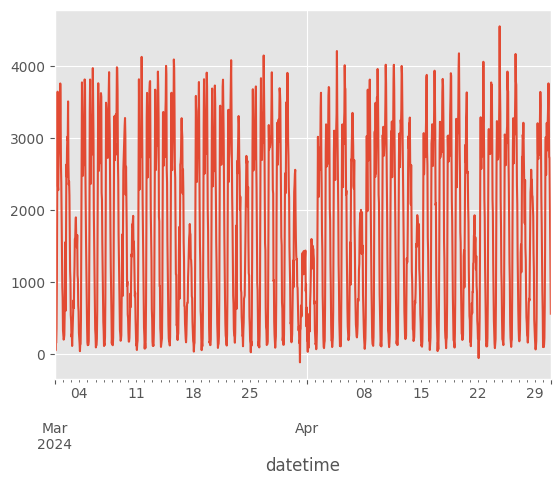

In [719]:
df_traffic_test.traffic.plot()

<Axes: >

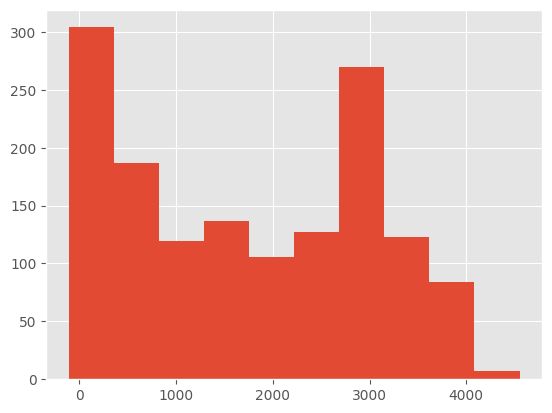

In [721]:
df_traffic_test.traffic.hist()

In [777]:
df_traffic_test['weekday'] = df_traffic_test.index.day_name()
hour = df_traffic_test.index.hour
bins = [0, 6, 12, 18, 21, 24]
labels = ['Midnight', 'Morning', 'Afternoon', 'Evening', 'Night']
df_traffic_test['time_of_day'] = pd.cut(hour, bins=bins, labels=labels, right=False, include_lowest=True)

In [779]:
df_traffic_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2024-03-01 00:00:00 to 2024-04-30 23:00:00
Freq: h
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   street       1464 non-null   object  
 1   segment      1464 non-null   object  
 2   lat          1464 non-null   float64 
 3   lon          1464 non-null   float64 
 4   h3res13      1464 non-null   object  
 5   traffic      1464 non-null   int32   
 6   weekday      1464 non-null   object  
 7   time_of_day  1464 non-null   category
dtypes: category(1), float64(2), int32(1), object(4)
memory usage: 87.4+ KB


In [781]:
df_traffic_test.head(10)

,street,segment,lat,lon,h3res13,traffic,weekday,time_of_day
datetime,,,,,,,,
2024-03-01 00:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,0,Friday,Midnight
2024-03-01 01:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,232,Friday,Midnight
2024-03-01 02:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,53,Friday,Midnight
2024-03-01 03:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,167,Friday,Midnight
2024-03-01 04:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,158,Friday,Midnight
2024-03-01 05:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,364,Friday,Midnight
2024-03-01 06:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,1037,Friday,Morning
2024-03-01 07:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,2383,Friday,Morning
2024-03-01 08:00:00,Wał Miedzeszyński,Krokusów - Werbeny,52.1509,21.1883,8d1f5350022097f,3644,Friday,Morning


In [725]:
df_traffic_test.lat.value_counts()

lat
52.1509    1464
Name: count, dtype: int64

In [727]:
df_traffic_test.lon.value_counts()

lon
21.1883    1464
Name: count, dtype: int64

In [767]:
from folium.plugins import TimestampedGeoJson
from matplotlib import cm
import json
min_lat = df_traffic_test['lat'].min()
max_lat = df_traffic_test['lat'].max()
min_lon = df_traffic_test['lon'].min()
max_lon = df_traffic_test['lon'].max()
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
min_traffic = df_traffic_test['traffic'].min()
max_traffic = df_traffic_test['traffic'].max()
MiniMap().add_to(m)
LocateControl().add_to(m)
def get_color(value):
    norm = (value - min_traffic) / (max_traffic - min_traffic + 1e-6)  # normalize traffic
    rgba = cm.get_cmap('RdYlGn_r')(norm)
    return f'#{int(rgba[0]*255):02x}{int(rgba[1]*255):02x}{int(rgba[2]*255):02x}'
features = []
for idx, row in df_traffic_test.iterrows():
    timestamp = idx.strftime("%Y-%m-%dT%H:%M:%S")  # Hourly format
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['lon'], row['lat']],
        },
        'properties': {
            'time': timestamp,  # Using timestamp in ISO format
            'style': {
                'color': get_color(row['traffic']),
                'fillColor': get_color(row['traffic']),
                'radius': 10 + (row['traffic'] / max_traffic) * 20,  # Increased radius size for better visibility
                'fillOpacity': 0.7,
            },
            'icon': 'circle',
            'popup': f"Traffic: {row['traffic']}<br>Time: {timestamp}"
        }
    }
    features.append(feature)
geojson = {
    'type': 'FeatureCollection',
    'features': features
}
TimestampedGeoJson(
    geojson,
    transition_time=200,  # time between frames in milliseconds
    auto_play=True,
    loop=True,  # Set to loop for continuous playback
    add_last_point=True
).add_to(m)
m

In [814]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_true = df_traffic['traffic']
y_pred = result_sarima_traffic.predict(start=start, end=end)
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "R²": r2
    }

In [816]:
metrics = evaluate_metrics(y_true, y_pred)
print(metrics)

{'MAE': 144.4540387946198, 'RMSE': 204.69924799968487, 'MAPE (%)': 26.54314471750274, 'R²': 0.9729988999420599}


In [812]:
rmse = mean_squared_error(y_true, y_pred) ** 0.5
print(f'RMSE: {rmse}')

RMSE: 204.69924799968487


In [818]:
df_traffic_test2 = df_traffic_test.copy()

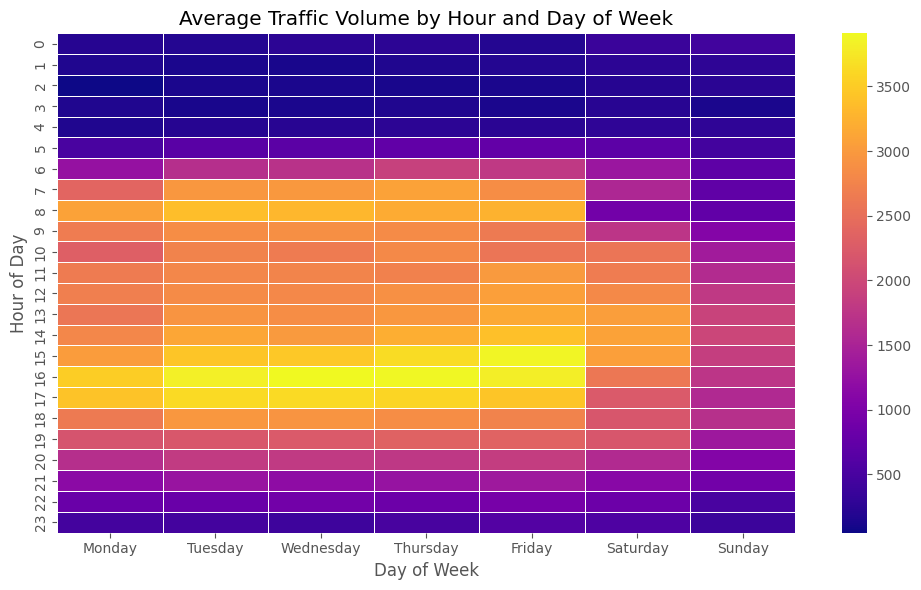

In [886]:
df = df_traffic_test.copy()
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_name'] = df.index.day_name()
pivot = df.pivot_table(index='hour', columns='day_name', values='traffic', aggfunc='mean')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot[day_order]
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='plasma', annot=False, 
            annot_kws={"size": 10, "weight": 'bold', "color": 'white', "alpha": 1}, linewidths=0.5)
plt.title("Average Traffic Volume by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

In [888]:
df_traffic_test.to_csv('test-data.csv')